## In This Notebook we will calculate residuals from our Random Forest Models

In [1]:
import math

#### Making our wokring directory

In [2]:
# Set a working directory
import os

directory_path = '/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/'
os.chdir(directory_path)


In [3]:
%run python/04_Populations-model-fitting/01_model-preparation.ipynb


In [4]:
import pandas as pd

tn413_path = 'data/modified/RF_ready_tn413.csv'
#using pandas to read in as a df
tn413 = (pd.read_csv(tn413_path,parse_dates=[0]))
#taking a peak at the data
tn413.head(3)


,population,time,lat,lon,NO3NO2,PO4,Fe,SiO4,Satellite_CHL,temp,salin,biomass
0,non_pro_syn,2023-02-25 05:40:00,21.3067,-157.036600,0.000562,0.212505,0.000433,2.092356,0.072018,24.03829,34.93311,6.716405
1,non_pro_syn,2023-02-25 05:50:00,21.3142,-157.032100,0.000562,0.212505,0.000433,2.092356,0.072018,24.01350,34.92320,10.023072
2,prochloro,2023-02-25 05:50:00,21.3141,-157.031633,0.000562,0.212505,0.000433,2.092356,0.072018,24.01350,34.92320,3.441297


### First we will load each random forest model into our notebook

In [5]:
import joblib
# Prochlorooccus
rf_pro = joblib.load("RF_models/random_forest_pro.joblib")

# Synechococus
rf_syn = joblib.load("RF_models/random_forest_syn.joblib")

# None Pro or Syn
rf_non = joblib.load("RF_models/random_forest_non.joblib")


## To make residuals we will predict on all available data for each picophytoplankton's population

In [6]:
def add_predictions_to_dataframe(rf_pro, rf_syn, rf_non, features_pro, features_syn, features_non, tn413):
    # Filter dataframes based on PopulationName
    dfs = [tn413[tn413['population'] == name].copy() for name in ['prochloro', 'synecho', 'non_pro_syn']]
    
    # Use the forest's predict method on the test data
    predictions = [rf.predict(features) for rf, features in zip([rf_pro, rf_syn, rf_non], [features_pro, features_syn, features_non])]
    
    # Add 'Prediction' and 'Errors' columns to each dataframe
    for df, preds in zip(dfs, predictions):
        df.rename(columns={'biomass': 'Actual'}, inplace=True)
        df['Prediction'] = preds
        df['residuals'] = df['Actual'] - df['Prediction']
        
    
    return dfs[0], dfs[1], dfs[2]

# Call the function and assign the returned dataframes to variables
rf_pro, rf_syn, rf_non = add_predictions_to_dataframe(rf_pro, rf_syn, rf_non, features_pro, features_syn, features_non, tn413)



In [14]:
rf_pro.head()

,population,time,lat,lon,NO3NO2,PO4,Fe,SiO4,Satellite_CHL,temp,salin,Actual,Prediction,residuals
2,prochloro,2023-02-25 05:50:00,21.314100,-157.031633,0.000562,0.212505,0.000433,2.092356,0.072018,24.01350,34.92320,3.441297,3.185283,0.256014
4,prochloro,2023-02-25 06:00:00,21.312500,-157.019100,0.000562,0.212505,0.000433,2.092356,0.072018,23.98739,34.93976,3.929065,3.329324,0.599741
6,prochloro,2023-02-25 06:10:00,21.311667,-156.997433,0.000534,0.211138,0.000450,2.089565,0.072336,23.98893,34.94376,3.386742,2.590640,0.796103
8,prochloro,2023-02-25 06:20:00,21.311167,-156.982933,0.000534,0.211138,0.000450,2.089565,0.072336,23.98837,34.94295,3.329084,2.632280,0.696804
10,prochloro,2023-02-25 06:30:00,21.309400,-156.963100,0.000534,0.211138,0.000450,2.089565,0.072336,24.00662,34.96166,2.862350,2.621811,0.240539


In [15]:
import plotly.graph_objects as go

def create_globe_scatter_plot(df, title_prefix="Prochlorococcus"):
    # Create a 3D scatter plot on a globe
    fig = go.Figure(data=go.Scattergeo(
        lat=df['lat'],
        lon=df['lon'],
        mode='markers',
        marker=dict(
            size=4,
            color=df['residuals'],
            colorscale='RdBu',
            cmin=min(df['residuals']),
            cmax=max(df['residuals']),
            colorbar=dict(title='Residuals (pgC/L)')
        )
    ))

    # Set the projection type to 'orthographic' for a globe
    fig.update_geos(projection_type='orthographic')

    # Set the title
    title = f"{title_prefix} Biomass Residuals"
    fig.update_layout(title=title)

    # Show the figure
    fig.show()
    f"{title_prefix} Biomass Residuals"
    fig.write_html(f"figures/globe_heatmap-residuals_{title_prefix}.html")


In [17]:
create_globe_scatter_plot(df=rf_pro, title_prefix='Prochlorococcus')
create_globe_scatter_plot(df=rf_syn, title_prefix='Synechococcus')
create_globe_scatter_plot(df=rf_non, title_prefix='Picoeukaryote')

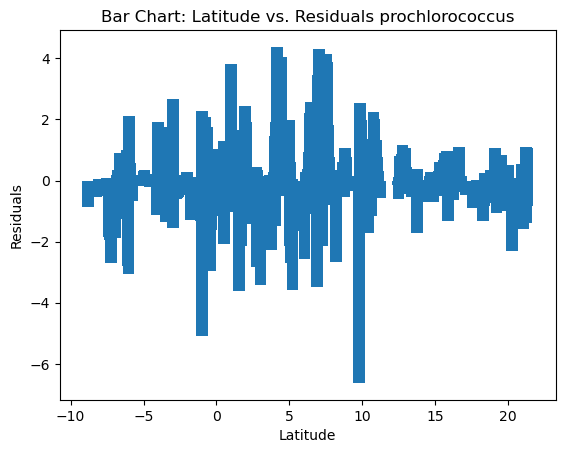

In [12]:
import matplotlib.pyplot as plt

# Extract the 'lat' and 'residuals' columns from the rf_pro dataframe
latitudes = rf_pro['lat']
residuals = rf_pro['residuals']

# Create a bar chart
plt.bar(latitudes, residuals)

# Set the x-axis label
plt.xlabel('Latitude')

# Set the y-axis label
plt.ylabel('Residuals')

# Set the title of the chart
plt.title('Bar Chart: Latitude vs. Residuals prochlorococcus')

# Display the chart
plt.show()


In [13]:
# !pip install contextily

In [9]:
#!pip install plotly==5.15.0
